In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import torch
import random
import sys
import matplotlib.pyplot as plt
device = 'cuda' if torch.cuda.is_available() else 'cpu'

from ex_biology import p
sys.path.append('preprocessing')
import data
import neural_networks

# adaptive-wavelets modules
sys.path.append('../..')
from src import adaptive_wavelets
from src.dsets.biology import dset
from src.visualize import cshow, plot_1dfilts, plot_1dreconstruct, plot_wavefun

In [2]:
# parameters for initialization
p.wave = 'db5'
p.J = 4
p.mode = 'zero'
p.init_factor = 1
p.noise_factor = 0    
p.const_factor = 0
p.num_epochs = 100
p.lamL1wave = 0.0001
p.lamL1attr = 0.0

In [3]:
# load data and model
train_loader, test_loader = dset.get_dataloader(p.data_path, 
                                                batch_size=p.batch_size,
                                                is_continuous=p.is_continuous)   

model = dset.load_pretrained_model(p.model_path, device=device)  

# prepare model
random.seed(p.seed)
np.random.seed(p.seed)
torch.manual_seed(p.seed)  

wt = adaptive_wavelets.DWT1d(wave=p.wave, mode=p.mode, J=p.J, 
                             init_factor=p.init_factor, 
                             noise_factor=p.noise_factor,
                             const_factor=p.const_factor).to(device)
wt.train()

# train
params = list(wt.parameters())
optimizer = torch.optim.Adam(params, lr=p.lr)
loss_f = adaptive_wavelets.get_loss_f(lamlSum=p.lamlSum, lamhSum=p.lamhSum, lamL2norm=p.lamL2norm, 
                                      lamCMF=p.lamCMF, lamConv=p.lamConv, lamL1wave=p.lamL1wave, lamL1attr=p.lamL1attr)
trainer = adaptive_wavelets.Trainer(model, wt, optimizer, loss_f, target=p.target, 
                                    use_residuals=True, attr_methods=p.attr_methods, 
                                    device=device, n_print=5)      

Starting Training Loop...
Train Epoch: 0 [1044/2936 (97%)]	Loss: 0.000437
====> Epoch: 0 Average train loss: 0.0043
Train Epoch: 5 [1044/2936 (97%)]	Loss: 0.000460
====> Epoch: 5 Average train loss: 0.0004
Train Epoch: 10 [1044/2936 (97%)]	Loss: 0.000467
====> Epoch: 10 Average train loss: 0.0004
Train Epoch: 15 [1044/2936 (97%)]	Loss: 0.000445
====> Epoch: 15 Average train loss: 0.0004
Train Epoch: 20 [1044/2936 (97%)]	Loss: 0.000462
====> Epoch: 20 Average train loss: 0.0004
Train Epoch: 25 [1044/2936 (97%)]	Loss: 0.000426
====> Epoch: 25 Average train loss: 0.0004
Train Epoch: 30 [1044/2936 (97%)]	Loss: 0.000439
====> Epoch: 30 Average train loss: 0.0004
Train Epoch: 35 [1044/2936 (97%)]	Loss: 0.000431
====> Epoch: 35 Average train loss: 0.0004
Train Epoch: 40 [1044/2936 (97%)]	Loss: 0.000457
====> Epoch: 40 Average train loss: 0.0004
Train Epoch: 45 [1044/2936 (97%)]	Loss: 0.000419
====> Epoch: 45 Average train loss: 0.0004
Train Epoch: 50 [1044/2936 (97%)]	Loss: 0.000425
====> Epo

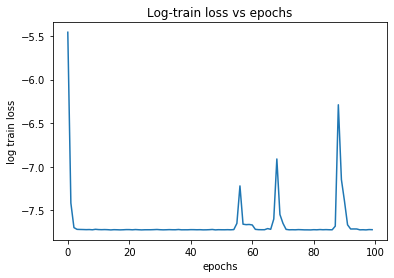

In [4]:
# run
trainer(train_loader, epochs=p.num_epochs)

plt.plot(np.log(trainer.train_losses))
plt.xlabel("epochs")
plt.ylabel("log train loss")
plt.title('Log-train loss vs epochs')
plt.show()

Reconstruction error=0.00000


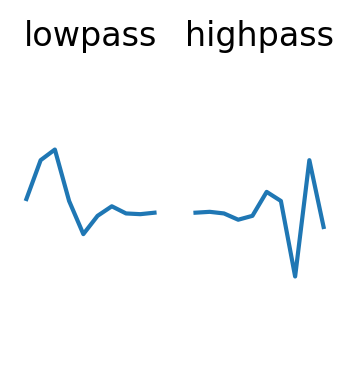

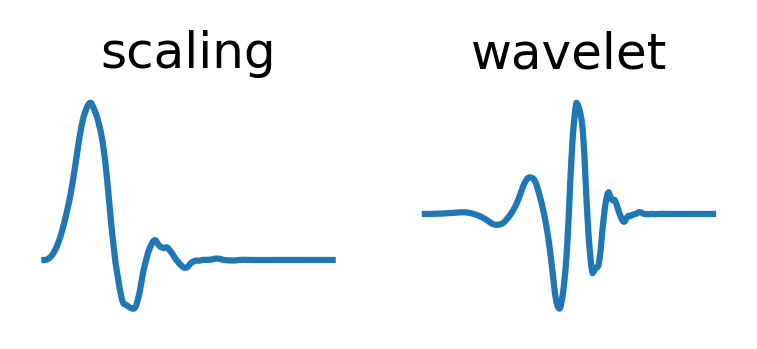

In [5]:
data = iter(test_loader).next()[0].to(device)
data_t = wt(data)
recon = wt.inverse(data_t)

print("Reconstruction error={:.5f}".format(torch.norm(recon - data)**2/data.size(0)))

# get 2d wavelet filters
filt = adaptive_wavelets.get_1dfilts(wt)
phi, psi, x = adaptive_wavelets.get_wavefun(wt)

plot_1dfilts(filt, is_title=True, figsize=(2,2))
plot_wavefun((phi, psi, x), is_title=True, figsize=(3,1))